# Sistema de Recomendacion de Peliculas.

En esta etapa usaremos nuestro dataframe ya analizado para crear un sistema de recomendacion de peliculas basado en el resumen de cada pelicula. nuestro sistema recomendara las 5 peliculas mas parecidas por orden de votacion.

Primero importemos nuestras herramientas

In [69]:
import itertools
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Y traigamos nuestro dataframe preparado

In [90]:
data = pd.read_csv('data/df_ml.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
df = data.copy()
print(df.shape)
df.head()

(1888, 4)


id                        title  vote_average  \
0   19404  Dilwale Dulhania Le Jayenge           9.1   
1     278     The Shawshank Redemption           8.5   
2     238                The Godfather           8.5   
3  372058                   Your Name.           8.5   
4     155              The Dark Knight           8.3   

                                            overview  
0  raj rich carefree happy go lucky second genera...  
1  framed double murder wife lover upstanding ban...  
2  spanning year chronicle fictional italian amer...  
3  high schoolers mitsuha taki complete stranger ...  
4  batman raise stake war crime help lt jim gordo...

Observamos que solo 1888 peliculas estaremos trabajando, esta drastica reduccion personalmente la hice ya que no recomendaria peliculas que tengan menos de 500 votos a un cliente potencial, ya que podria no ser realmente buena o parecida.

Filtremos las stopwords para nuestro procesamiento del lenguaje

In [71]:
stopwords = nltk.corpus.stopwords.words('english')
filtrar = []
if True:
    filtrar.append("u")
    filtrar.append("new")
    filtrar.append("The")
    filtrar.append("In")
    filtrar.append("A")

Tokenizemos y filtremos las palabras de nuestra columna overview

In [72]:
lista = []
for i in range(df.shape[0]):
    titular = df.iloc[i, -1]
    titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular)
    titular = [word for word in titular if word not in stopwords]
    titular = [word for word in titular if word not in filtrar]

    lista.append(titular)

In [73]:
lista = list(itertools.chain(*lista))
lista[0:10]

['raj',
 'rich',
 'carefree',
 'happy',
 'go',
 'lucky',
 'second',
 'generation',
 'nri',
 'simran']

Tambien podemos observar la frecuencia de las palabras

In [74]:
freq_peliculas =nltk.FreqDist(lista)
freq_peliculas

FreqDist({'life': 421, 'find': 351, 'world': 322, 'one': 258, 'year': 247, 'young': 230, 'must': 215, 'man': 210, 'family': 207, 'two': 201, ...})

Creemos un dataframe con las palabras y su frecuencia

In [75]:
palabras_peliculas = pd.DataFrame(list(freq_peliculas.items()), columns=['palabra', 'frecuencia'])
palabras_peliculas.head()

palabra  frecuencia
0       raj           2
1      rich          20
2  carefree           5
3     happy          17
4        go         119

In [76]:
palabras_peliculas.sort_values('frecuencia', ascending=False, inplace=True)
palabras_peliculas.head(15)

palabra  frecuencia
45      life         421
141     find         351
218    world         322
102      one         258
69      year         247
224    young         230
115     must         215
186      man         210
32    family         207
114      two         201
1126  friend         193
176      get         172
86      take         172
29      love         167
202    story         148

In [77]:
palabras_peliculas.reset_index(drop=True, inplace=True)

y lo grafiquemos para entender un poco mejor nuestras muestras

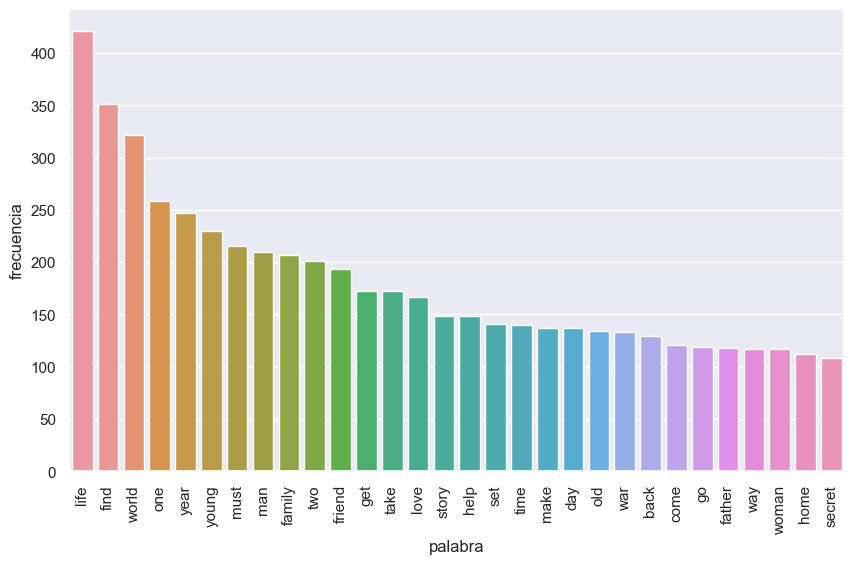

In [78]:
plt.figure(figsize=(10,6))
plot = sns.barplot(x = palabras_peliculas.iloc[:30].palabra, y=palabras_peliculas.iloc[:30].frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Es interesante que se repita tantas veces la palabra life :D. bueno sigamos.

In [91]:
#Instanciamos el lemmatizador
lemmatizer = WordNetLemmatizer()


Creamos una funcion para hacer el preprocesamiento.

In [80]:
def preprocesamiento(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-zA-Z]', ' ', texto)
    tokens = texto.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords]
    texto_procesado = ' '.join(tokens)
    return texto_procesado

se lo aplicamos a la columna "overview"

In [81]:
df['overview'] = df['overview'].apply(preprocesamiento)


In [82]:
df.head()

id                        title  vote_average  \
0   19404  Dilwale Dulhania Le Jayenge           9.1   
1     278     The Shawshank Redemption           8.5   
2     238                The Godfather           8.5   
3  372058                   Your Name.           8.5   
4     155              The Dark Knight           8.3   

                                            overview  
0  raj rich carefree happy go lucky second genera...  
1  framed double murder wife lover upstanding ban...  
2  spanning year chronicle fictional italian amer...  
3  high schoolers mitsuha taki complete stranger ...  
4  batman raise stake war crime help lt jim gordo...

Podemos extraer ya este dataframe para su posterior uso en nuestra api main.

In [83]:
#df.to_csv('data/df_ml.csv')

Vectorizamos y entrenamos.

In [84]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['overview'])

Creamos la matriz de similitud.

In [85]:
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [86]:
import joblib

Extraemos la matriz en formato pickle para trabajarla en nuestra api de manera mas eficiente.

In [87]:
joblib.dump(similarity_matrix, 'pickle/similarity_matrix.pkl')

['pickle/similarity_matrix.pkl']

Creamos una funcion de prueba para recomendar las peliculas.

In [88]:
def get_recommendations(nombre_pelicula, similarity_matrix, num_recommendations=5):
    movie_index = data[data['title'] == nombre_pelicula].index[0]
    similarity_scores = list(enumerate(similarity_matrix[movie_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_scores = similarity_scores[1:num_recommendations+1]
    top_movie_indices = [score[0] for score in top_scores]
    top_movies = data['title'].iloc[top_movie_indices]
    dicc = {}
    for i, v in enumerate(top_movies.values):
        dicc[i + 1] = v
    return dicc

In [89]:
recommended_movies = get_recommendations('Titanic', similarity_matrix)
print(recommended_movies)

{1: 'The Legend of 1900', 2: 'Ghost Ship', 3: 'Event Horizon', 4: 'Boyhood', 5: 'Deepwater Horizon'}


El Resultado me es perfectamente viable para lo que se requiere del proyecto. por lo que ya estamos listos para deployarlo. 

Gracias por acompañarme en mi primer proyecto! espero sea de su agrado.